In [1]:
import os
import sys
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NLinearModel, NBEATSModel
from darts.utils.missing_values import fill_missing_values

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

PROJECT_FOLDER = pathlib.Path(os.getcwd()).resolve().parent
sys.path.append(str(PROJECT_FOLDER / 'src'))
from utils.dataset_utils import DatasetUtils

/home/migisen/Study/misis-dshack/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Конфиг

In [2]:
PATH_TO_STOCKS = PROJECT_FOLDER / 'data' / 'SBER_210111_230531.csv'
TEST_SIZE = 0.1
VAL_SIZE = 0.25

INPUT_CHUNK = 128
OUTPUT_CHUNK = 20
EARLYSTOP_PATIENCE = 20
LOSS_FN = torch.nn.L1Loss()

# Загрузка данных

In [3]:
dataset_utils = DatasetUtils()
daily_sber_stocks = dataset_utils.get_daily_df(PATH_TO_STOCKS)
daily_sber_stocks

,<DATE>,<TIME>,<TICKER>,<PER>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATETIME>,,,,,,,,,
2021-01-11,20210111,230000,SBER,60,289.42,289.46,288.88,289.37,111758030
2021-01-12,20210112,230000,SBER,60,288.56,289.65,288.48,289.56,78534840
2021-01-13,20210113,230000,SBER,60,284.43,285.16,284.18,284.56,67553650
2021-01-14,20210114,230000,SBER,60,285.05,285.30,284.75,284.99,74664310
2021-01-15,20210115,230000,SBER,60,276.98,277.20,276.78,277.09,73408800
...,...,...,...,...,...,...,...,...,...
2023-05-27,20230527,100000,SBER,60,248.33,248.43,248.06,248.10,1521910
2023-05-29,20230529,230000,SBER,60,251.60,251.92,251.50,251.70,66119980
2023-05-30,20230530,230000,SBER,60,245.25,245.35,244.40,244.47,82764840


## Создаем Darts Timeseries

In [4]:
sber_daily_darts = TimeSeries.from_dataframe(daily_sber_stocks[['<CLOSE>']], fill_missing_dates=True, freq='D')
sber_daily_darts

<TimeSeries (DataArray) (<DATETIME>: 872, component: 1, sample: 1)>
array([[[289.37]],

       [[289.56]],

       [[284.56]],

       [[284.99]],

       [[277.09]],

       [[276.9 ]],

       [[   nan]],

       [[279.73]],

       [[277.9 ]],

       [[279.6 ]],

...

       [[235.73]],

       [[244.7 ]],

       [[243.99]],

       [[248.3 ]],

       [[248.1 ]],

       [[   nan]],

       [[251.7 ]],

       [[244.47]],

       [[245.68]],

       [[246.17]]])
Coordinates:
  * <DATETIME>  (<DATETIME>) datetime64[ns] 2021-01-11 2021-01-12 ... 2023-06-01
  * component   (component) object '<CLOSE>'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

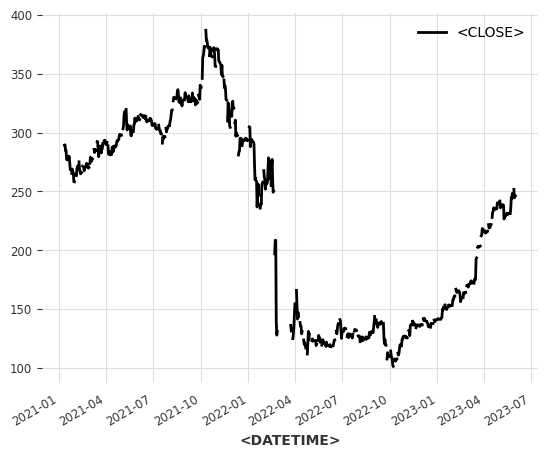

In [5]:
sber_daily_darts.plot()

Интерполируем пропущенные значения

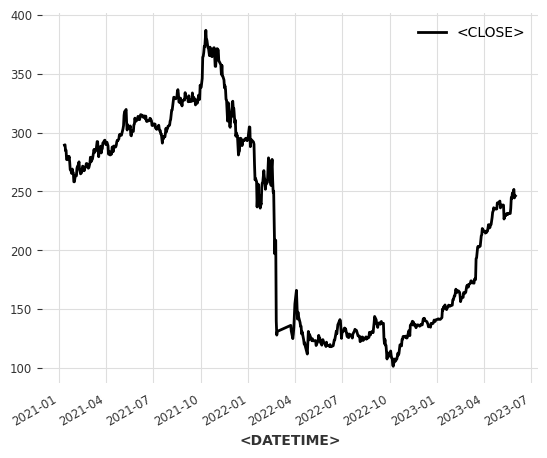

In [6]:
sber_daily_darts = fill_missing_values(sber_daily_darts)
sber_daily_darts.plot()

Разделим данные на обучающую и тестовы, пока не будем учитывать структурный сдвиг.

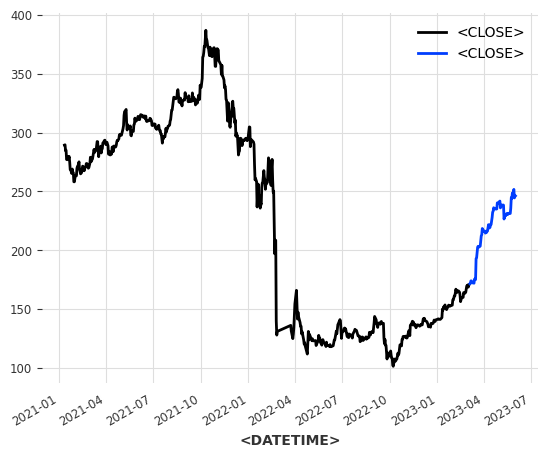

In [7]:
train_series, test_series = sber_daily_darts.split_before(1 - TEST_SIZE)
train_series.plot()
test_series.plot()

Добавим валидационную выборку

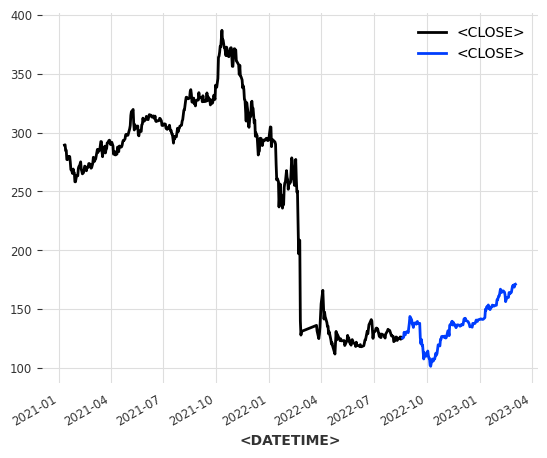

In [8]:
train_series, val_series = train_series.split_before(1 - VAL_SIZE)
train_series.plot()
val_series.plot()

Заскэйлим данные от 0 до 1

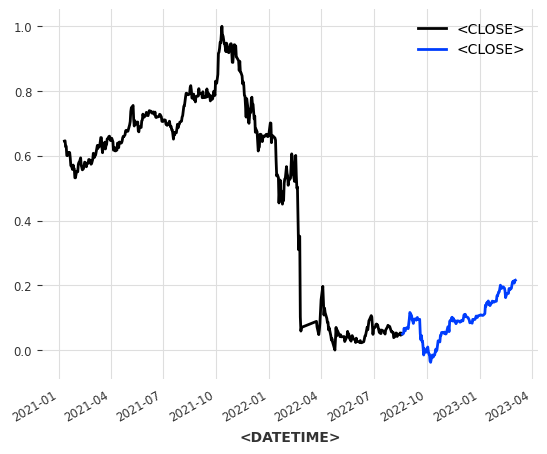

In [9]:
scaler = Scaler()
train_series_scaled = scaler.fit_transform(train_series)
val_series_scaled = scaler.transform(val_series)
train_series_scaled.plot()
val_series_scaled.plot()

# Построение модели

In [10]:
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=EARLYSTOP_PATIENCE,
    min_delta=0.00005,
    mode='min'
)
model_linearn = NLinearModel(
    input_chunk_length=INPUT_CHUNK, 
    output_chunk_length=OUTPUT_CHUNK, 
    random_state=42, 
    pl_trainer_kwargs={'callbacks': [early_stopping_callback]},
    optimizer_kwargs={'lr': 1e-3},
    loss_fn=LOSS_FN
    )
model_linearn.fit(series=train_series_scaled, val_series=val_series_scaled, epochs=100, verbose=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


NLinearModel(shared_weights=False, const_init=True, normalize=False, use_static_covariates=True, input_chunk_length=128, output_chunk_length=20, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f5ea3717e50>]}, optimizer_kwargs={'lr': 0.001}, loss_fn=L1Loss())

In [11]:
model_nbeats = NBEATSModel(
    input_chunk_length=INPUT_CHUNK, 
    output_chunk_length=OUTPUT_CHUNK, 
    random_state=42,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    loss_fn=LOSS_FN,
    pl_trainer_kwargs={'callbacks': [early_stopping_callback]},
)

model_nbeats.fit(series=train_series_scaled, val_series=val_series_scaled, epochs=100, verbose=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


NBEATSModel(generic_architecture=False, num_stacks=30, num_blocks=3, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=128, output_chunk_length=20, random_state=42, n_epochs=100, nr_epochs_val_period=1, loss_fn=L1Loss(), pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f5ea59ca150>]})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.74it/s]


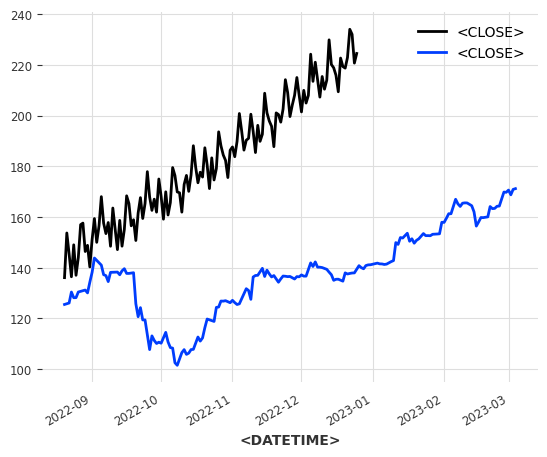

In [12]:
pred_sber_nbeats = model_nbeats.predict(series=train_series_scaled, n=128)

pred_sber_nbeats = scaler.inverse_transform(pred_sber_nbeats)
pred_sber_nbeats.plot()
val_series.plot()
# sber_daily_darts.plot()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 311.50it/s]


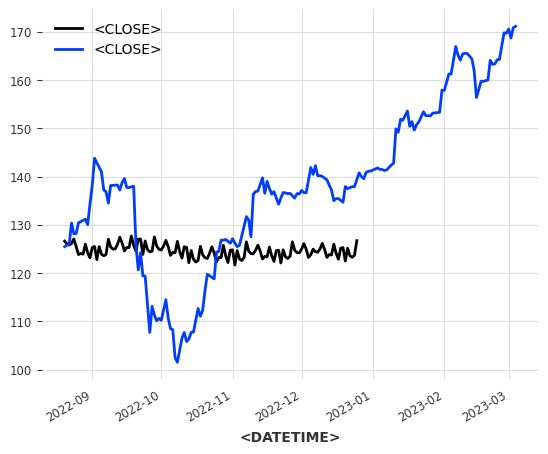

In [13]:
pred_sber = model_linearn.predict(series=train_series_scaled, n=128)

pred_sber = scaler.inverse_transform(pred_sber)
pred_sber.plot()
val_series.plot()
# sber_daily_darts.plot()

# Структурный сдвиг
В данных наблюдается структурный сдвиг в феврале 2022 года.

Прогнозирование, а также анализ данных со структурными сдвигами является отдельным направлением исследования.
В рамках данной работы попробуем просто выровнять среднее значение ряда.

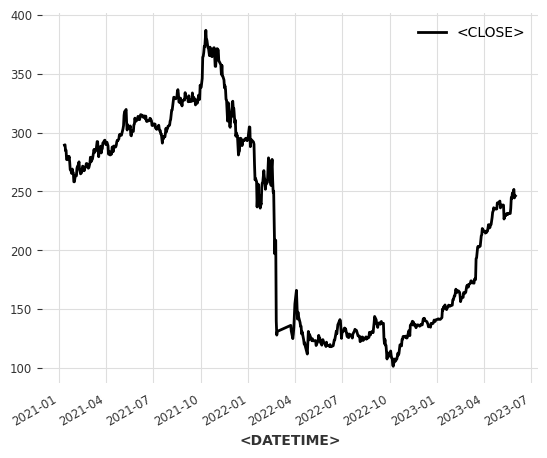

In [14]:
sber_daily_darts_seasons = sber_daily_darts.copy()
sber_daily_darts_seasons.plot()

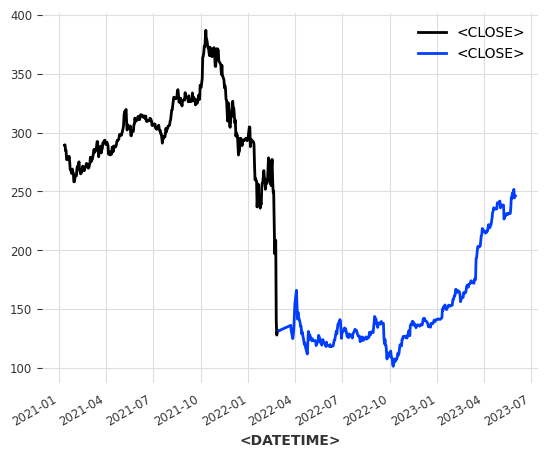

In [15]:
first_half = sber_daily_darts_seasons[:pd.to_datetime('2022-03-1')]
second_half = sber_daily_darts_seasons[pd.to_datetime('2022-03-1'):]
first_half.plot()
second_half.plot()

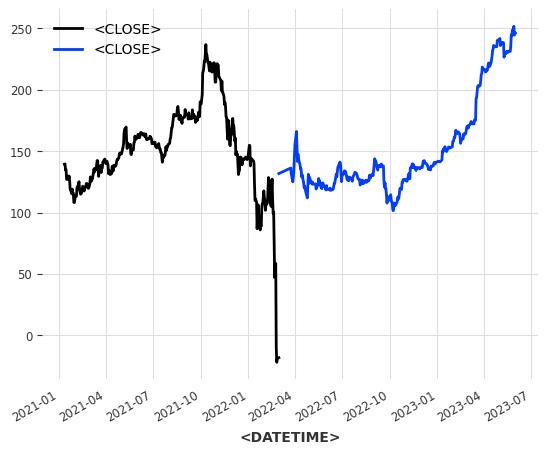

In [16]:
first_half = first_half - (np.mean(first_half.values()) - np.mean(second_half.values()))
first_half.plot()
second_half.plot()

Уберем момент падения и склеим данные обратно

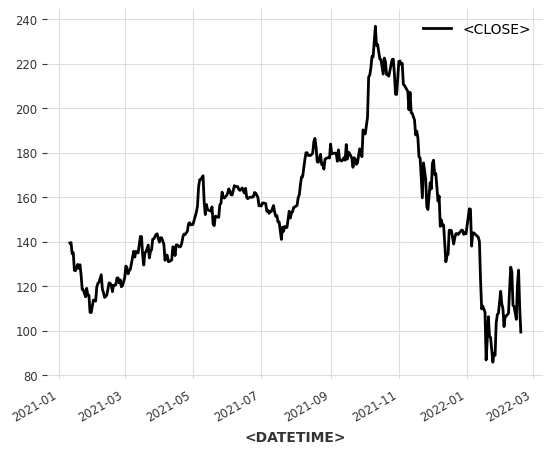

In [17]:
first_half[:pd.to_datetime('2022-02-18')].plot()

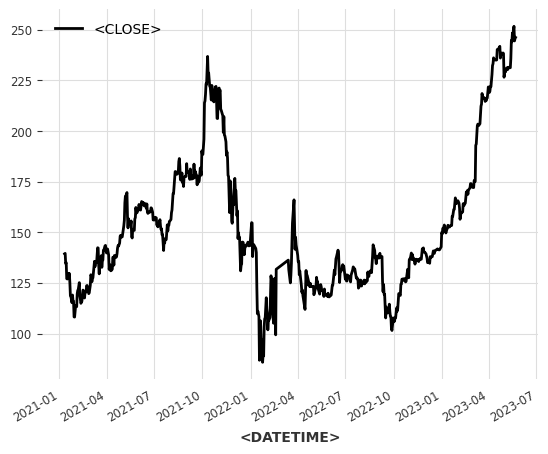

In [18]:
sber_daily_structural_adjasted = first_half[:pd.to_datetime('2022-02-18')].concatenate(second_half, ignore_time_axis=True)
sber_daily_structural_adjasted.plot()

## Создадим обучающую, валидационную и тестовую выборку


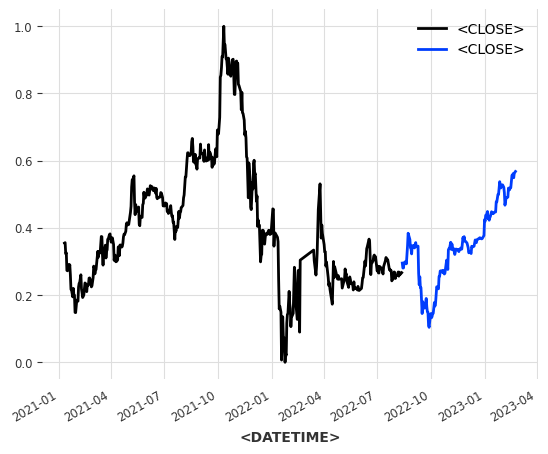

In [19]:
train_val_series_adj, test_series_adj = sber_daily_structural_adjasted.split_before(1 - TEST_SIZE)
train_series_adj, val_series_adj = train_val_series_adj.split_before(1 - VAL_SIZE)

scaler_adj = Scaler()
train_series_adj_scaled = scaler_adj.fit_transform(train_series_adj)
val_series_adj_scaled = scaler_adj.transform(val_series_adj)
train_series_adj_scaled.plot()
val_series_adj_scaled.plot()

## Обучим модель

In [20]:
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=EARLYSTOP_PATIENCE,
    min_delta=0.00005,
    mode='min'
)
model = NLinearModel(
    input_chunk_length=INPUT_CHUNK, 
    output_chunk_length=OUTPUT_CHUNK, 
    random_state=42, 
    pl_trainer_kwargs={'callbacks': [early_stopping_callback]},
    optimizer_kwargs={'lr': 1e-3},
    loss_fn=LOSS_FN,
    )
model.fit(series=train_series_adj_scaled, val_series=val_series_adj_scaled, epochs=100, verbose=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


NLinearModel(shared_weights=False, const_init=True, normalize=False, use_static_covariates=True, input_chunk_length=128, output_chunk_length=20, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f5e98686f90>]}, optimizer_kwargs={'lr': 0.001}, loss_fn=L1Loss())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.59it/s] 


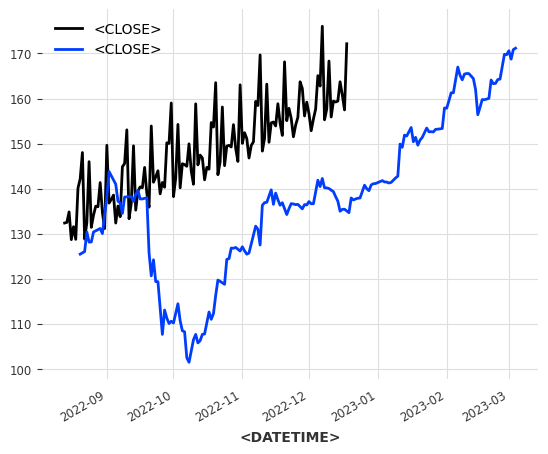

In [21]:
model_nbeats = NBEATSModel(
    input_chunk_length=INPUT_CHUNK, 
    output_chunk_length=OUTPUT_CHUNK, 
    random_state=42,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    pl_trainer_kwargs={'callbacks': [early_stopping_callback]},
    n_epochs=100,
    nr_epochs_val_period=1,
    loss_fn=LOSS_FN
)

model_nbeats.fit(series=train_series_adj_scaled, val_series=val_series_adj_scaled, epochs=100, verbose=False)
pred_sber_nbeats = model_nbeats.predict(series=train_series_adj_scaled, n=128)

pred_sber_nbeats = scaler_adj.inverse_transform(pred_sber_nbeats)
pred_sber_nbeats.plot()
val_series.plot()
# sber_daily_darts.plot()

In [22]:
pred_sber_adj = model.predict(series=train_series_adj_scaled, n=128)
pred_sber_adj = scaler_adj.inverse_transform(pred_sber_adj)

# sber_daily_darts.plot()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 271.69it/s]


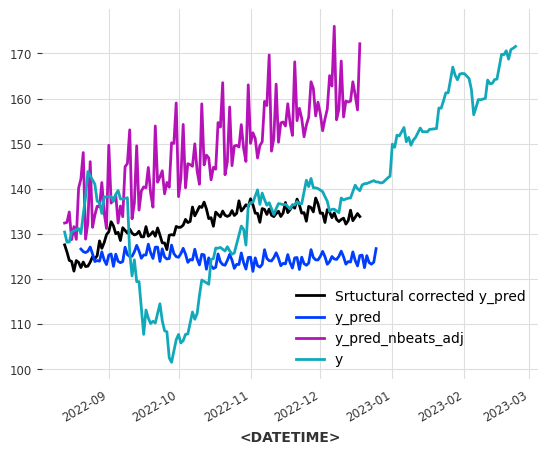

In [23]:
pred_sber_adj.plot(label='Srtuctural corrected y_pred')
pred_sber.plot(label='y_pred')
pred_sber_nbeats.plot(label='y_pred_nbeats_adj')
val_series_adj.plot(label='y')

# Сравнение моделей на тестовой выборке